# Implementation of Naive Bayes with m-Estimation
    using the car dataset from the UCI Machine Learning Repository. 
   (source: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation)


### Load modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

## Naive Bayes Implementation

In [2]:
class NaiveBayes(object):
  def __init__(self, data, class_attr, attributes = None):
    self.data = data
    self.class_attr = class_attr
    self.class_data = self.data[class_attr].values 
    self.attributes = data.dtypes.index[:-1] if not attributes else attributes
    self.class_counts = {}
    self.priors = {}
    self.conditional_prob = {}
    self.hypothesis = None
    self.prediction = list()
  
    
  def calculatePriors(self):
    '''
    Computes the relative frequency of each class.
  
    probability(class) =  How many  times it appears in cloumn
                          ____________________________________
                             total number of items/rows
  
    '''
    # count frequency of each class
    klasse, counts = np.unique(self.class_data, return_counts=True)
    
    # calculate prior of each class
    priors = counts.astype('float')/self.data.shape[0]
    
    # save class counts for conditional prob calculation
    for key,val in zip(klasse, counts):
      self.class_counts[key] = val
    
    # save priors
    for key,val in zip(klasse,priors):
      self.priors[key] = val
      
    
  def getClassFreq(self):
    '''Prints out the class frequency'''
    
    for klasse, freq in self.class_counts.items():
      print("Frequency of class '%s': %d" % (klasse, freq))
      
      
  def getPriors(self):
    '''Prints out the priors'''
    
    for klasse, prior in self.priors.items():
      print("P('%s') = %.2f%%"% (klasse,prior*100))
      
      
  def getDataAttributes(self):
    '''Prints out the attributes of the train set'''
    print('Attribute labels: ', [attr for attr in self.attributes])

    
  def getCP(self, attr, attr_type, class_value):
    '''
        Calculate individual conditional probabilites 
        P(outcome|evidence) =   P(evidence|outcome) x P(outcome)
                               __________________________________
                                        P(evidence)
    '''
    
    # number of training exmaples for which `attr` == `attr_type`
    # and `class_attr` == `class_value`
    # For further epxlanation see at the bottom of this notebook
    # `Illustration of boolean indexing into multiple columns` 
    n_c = self.data[(self.data[attr] == attr_type) & 
              (self.data[self.class_attr] == class_value)].shape[0]
    
    # prior estimate assuming uniform distribution
    # of attribute values
    p = 1.0/len(np.unique(self.data[attr]))
    
    
    n = self.class_counts[class_value]
    # Laplace smoothing
    m = 1
    
    # m-estimate of probability 
    cond_prob = (n_c + m*p)/ (n + m)
    
      
    return cond_prob
  
      
  def calculateConditionalProbabilities(self, hypothesis, verbose = False):
    
    for klasse in self.priors:
      self.conditional_prob[klasse] = {}
      for attr in hypothesis:
        self.conditional_prob[klasse].update(
          {hypothesis[attr]: self.getCP(attr, 
                                         hypothesis[attr], 
                                         klasse)})
    if verbose:
      import pprint 
      print("\nCalculated Conditional Probabilities: \n")
      pprint.pprint(self.conditional_prob[klasse])      
      

  def classify(self, test_set, verbose=False, samples=False):
    '''
        Calculates Likelihood of Evidence by multiplying 
        all individual probabilities with priors.
        (Outcome|Multiple Evidence) = P(Evidence1|Outcome) 
                                      x P(Evidence2|outcome) 
                                      x ... 
                                      x P(EvidenceN|outcome) 
                                      x P(Outcome)
    '''
    from functools import reduce
    
    if not self.priors:
      self.calculatePriors()
    
    if not samples:
      print('Classifying...')
    
    for row in test_set:
      self.calculateConditionalProbabilities(
        dict(zip(self.attributes, row)), verbose=verbose)
    
      if verbose:
        print("Result for input %s: " % row)

      result = dict()
      
      # Product over all individual probabilites
      # using functional programming (reduce)
      for i in self.conditional_prob:
        result[i] = reduce(lambda x, y: x*y, self.conditional_prob[i].values())*self.priors[i]
        if verbose:
          print("P('%s') = %.6f" % (i,result[i]))
          
      # get key of dict which contains max value
      # basically `argmax`
      label = max(result, key=result.get)
      
      if verbose:
        print('Classification: ', label)
        
      self.prediction.append(label)
    
    if not samples:
      print('Done.')
    
  def accuracy(self, labels):
    '''Computes prediction accuracy'''
  
    prediction = np.array(self.prediction)
    
    return (100.0 * np.sum(prediction == labels) 
                / prediction.shape[0])

## Test Naive Bayes on Tennis data set

In [3]:
tennis = pd.read_table('../ID3/tennis.txt')
tennis

,outlook,temperature,humidity,wind,playtennis
0,sunny,hot,high,weak,no
1,sunny,hot,high,strong,no
2,overcast,hot,high,weak,yes
3,rain,mild,high,weak,yes
4,rain,cool,normal,weak,yes
5,rain,cool,normal,strong,no
6,overcast,cool,normal,strong,yes
7,sunny,mild,high,weak,no
8,sunny,cool,normal,weak,yes
9,rain,mild,normal,weak,yes


In [4]:
class_attr = 'playtennis'
clf = NaiveBayes(data=tennis, class_attr=class_attr)

clf.calculatePriors()
clf.getPriors()
clf.getClassFreq()
clf.getDataAttributes()

# Classify new data
new_data = ['sunny', 'cool', 'high', 'strong']
clf.classify([new_data], verbose=True)

P('no') = 35.71%
P('yes') = 64.29%
Frequency of class 'no': 5
Frequency of class 'yes': 9
Attribute labels:  ['outlook', 'temperature', 'humidity', 'wind']
Classifying...

Calculated Conditional Probabilities: 

{'cool': 0.33333333333333337,
 'high': 0.34999999999999998,
 'strong': 0.34999999999999998,
 'sunny': 0.23333333333333334}
Result for input ['sunny', 'cool', 'high', 'strong']: 
P('no') = 0.019290
P('yes') = 0.006125
Classification:  no
Done.


**Without m-estimate the resulted probabilities are:**

P('yes') = 0.0053 **and** 
P('no') = 0.0206

**Here I chose *Laplace smoothing* with** $m=1$ **for **

   # $$\hat{P}(a_i|v_j) = \frac{n_c + m\cdot p}{n + m}$$
   
**differen weight $m$ would have lead to a different '*distortion*' of the probabilites**

### Classification with new attribute type

In [5]:
# Classify new data with unseen attr type `storm`
new_data = ['storm', 'cool', 'high', 'strong']
clf.classify([new_data], verbose=True)


Classifying...

Calculated Conditional Probabilities: 

{'cool': 0.33333333333333337,
 'high': 0.34999999999999998,
 'storm': 0.033333333333333333,
 'strong': 0.34999999999999998}
Result for input ['storm', 'cool', 'high', 'strong']: 
P('no') = 0.001929
P('yes') = 0.000875
Classification:  no
Done.


# Run Naive Bayes with Car Data Set

## Split Car Dataset into train and test set
    Used scikit-learn's built-in function for this since it's not relevant for understanding Naive Bayes
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [3]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('cardata.csv')

# .values converts pandas df to numpy array
# the required object type for `train_test_split`
X_train, X_test, y_train, y_test = train_test_split(
  data.values[:,:-1], data['class'].values, 
  test_size=1/3, 
  random_state=0) # set seed

# convert back to pandas DataFrame
labels = data.dtypes.index[:-1]
X_train = pd.DataFrame(X_train, columns=labels) 
X_test = pd.DataFrame(X_test, columns=labels)
X_train['class'] = y_train

# X_test['class'] = y_test

In [4]:
# Name of col that contains the outcome vals
class_attr = 'class'

# Instantiate new NB class
clf = NaiveBayes(data=X_train, class_attr=class_attr)

# Some output
clf.calculatePriors()
clf.getPriors()
clf.getClassFreq()
clf.getDataAttributes()

# Stop time for classification
import timeit

start_time = timeit.default_timer()
clf.classify(X_test.values)
print('Elapsed time: %.2f seconds.'% float(timeit.default_timer() - start_time))

# Compute accuracy
print('Accuracy: %.2f%%'% clf.accuracy(y_test))

P('acc') = 22.22%
P('unacc') = 70.23%
P('good') = 3.65%
P('vgood') = 3.91%
Frequency of class 'acc': 256
Frequency of class 'unacc': 809
Frequency of class 'good': 42
Frequency of class 'vgood': 45
Attribute labels:  ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
Classifying...
Done.
Elapsed time: 32.89 seconds.
Accuracy: 74.31%


### Determine the mean error rate over 100 different random samples of training data. 

In [8]:
accuracies = []
k = 100
for n in range(k):
  if(n%25 == 0):
    print('Iteration #{0}'.format(n))
    
  # pick new random sample
  X_train, X_test, y_train, y_test = train_test_split(
    data.values[:,:-1], data['class'].values, 
    test_size=1/3, 
    random_state=n) # change seed with each iteration

  # convert back to pandas DataFrame
  labels = data.dtypes.index[:-1]
  X_train = pd.DataFrame(X_train, columns=labels) 
  X_test = pd.DataFrame(X_test, columns=labels)
  X_train['class'] = y_train

  # Instantiate new NB class
  clf = NaiveBayes(data=X_train, class_attr=class_attr)

  # classify
  clf.classify(X_test.values, samples=True)

  # save accuracy
  accuracies.append(clf.accuracy(y_test))

Iteration #0
Iteration #25
Iteration #50
Iteration #75


### Mean error rate

In [9]:
print('Mean error rate over %d random samples: %.6f' % (k,
    np.mean(np.ones(len(accuracies)) - np.array(accuracies)/100)))

Mean error rate over 100 random samples: 0.255365


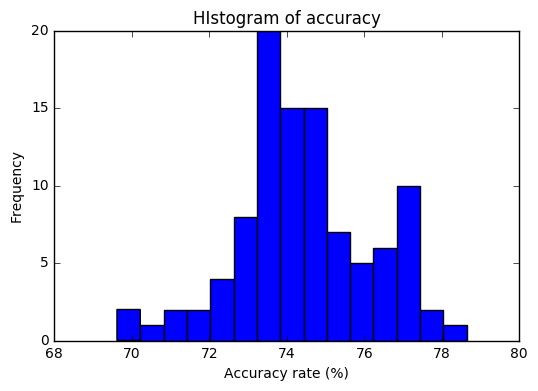

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(accuracies, bins=15)
plt.title('HIstogram of accuracy')
plt.ylabel('Frequency')
plt.xlabel('Accuracy rate (%)')
plt.show()

Compared to the K-means classification which classified all items belonging to one class and thus resulted to 70.02 accuracy, Naive Bayes does better. It yields a mean accuracy rate of ~74.5% in this case. This result could be improved though, by choosing a different weight **m** for the m-estimate -- as one can see in my implementation without the m-estimate (which would be the same as setting $m = 0$), where the average error rate over 100 random samples was 18.81% (or an average accuracy of 81.18%) https://github.com/reinka/coding/blob/master/MachineLearning/bayes/Naive%20Bayes.ipynb. So my guess is choosing a smaller $m$-value would result in less bias and thus higher accuracy. Technically, one could replace the hard coded $m$-value by one specified by the user during runtime, but since my implementation takes quite some time to compute the classification for the test set (~35 sec. So 100x35sec = 3500sec, so almost 1h for 100 random samples) I skipped this part.

### Furthermore, plot a confusion matrix for one sample. 
    Here I picked the last sample from the 100 samples.

Confusion matrix, without normalization
[[ 32  15  13   5]
 [  0   0   0   0]
 [ 96   9 387   6]
 [  0   3   1   9]]


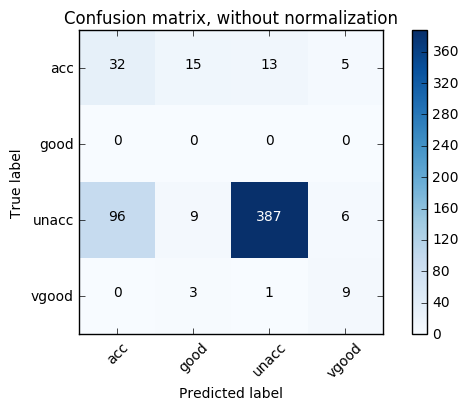

In [6]:
from sklearn.metrics import confusion_matrix

import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# compute confusion matrix
cnf_matrix = confusion_matrix(clf.prediction, y_test)

# plot parameters
np.set_printoptions(precision=2)
class_names = np.unique(X_train['class'])

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Confusion matrix, without normalization')

plt.show()

## Code explanation

### Illustration of boolean indexing into multiple columns

In [ ]:
data[(data['buying'] == 'low') & (data['class'] == 'acc')].head(15)

#### Count occurence of each outcome class to calculate prior 

In [ ]:
def classPrior(classcol):
  '''
  Computes the relative frequency of each class.
  
  probability(class) =    How many  times it appears in cloumn
                        __________________________________________
                            total number of items/rows
  
  @param    column containing outcome classes
  @return   zip object containing a list of
            tuples each of the kind (class, prior)
  '''
  val, counts = np.unique(classcol, return_counts=True)
  #print(val, counts)

  priors = counts.astype('float')/classcol.shape[0]

  return zip(val, priors)

df = data.values
for klasse, prior in classPrior(df[:,-1]):
  print("P('%s') = %.2f%%"% (klasse,prior*100))